In [6]:
import pandas as pd

In [7]:
api_industry = pd.read_csv('Industry_Codes_Data.csv')
api_industry.head(10)

,industry_code,industry_name
0,0,Total Nonfarm
1,5000000,Total Private
2,6000000,Goods Producing
3,7000000,Service-Providing
4,8000000,Private Service Providing
5,10000000,Mining and Logging
6,10113300,Logging
7,10210000,"Mining, Quarrying, and Oil and Gas Extraction"
8,10211000,Oil and Gas Extraction
9,10212000,Mining (except Oil and Gas)


In [8]:
api_industry = api_industry.iloc[2:].reset_index(drop=True)

In [9]:
# api_industry.to_csv('api_industry.csv', index=False)

In [11]:
print('unique values: ', len(api_industry['industry_name'].unique()))
print('=======')
print('null values summary: \n', api_industry.isna().sum())

unique values:  338
null values summary: 
 industry_code    0
industry_name    0
dtype: int64


In [12]:
linkedin_industry = pd.read_csv('industries.csv')
linkedin_industry.head(10)

,industry_id,industry_name
0,1,Defense and Space Manufacturing
1,3,Computer Hardware Manufacturing
2,4,Software Development
3,5,Computer Networking Products
4,6,"Technology, Information and Internet"
5,7,Semiconductor Manufacturing
6,8,Telecommunications
7,9,Law Practice
8,10,Legal Services
9,11,Business Consulting and Services


In [13]:
print('unique values: ', len(linkedin_industry['industry_name'].unique()))
print('=======')
print('null values summary: \n', linkedin_industry.isna().sum())

unique values:  389
null values summary: 
 industry_id       0
industry_name    34
dtype: int64


In [14]:
linkedin_industry.dropna(inplace=True)

In [ ]:
# linkedin_industry.to_csv('linkedin_industry.csv', index=False)

#### Semantic Matching (Sentence-BERT)

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import numpy as np

# Combine both datasets for clustering
combined_names = pd.concat([api_industry['industry_name'], linkedin_industry['industry_name']]).unique()

# TF-IDF vectorization
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(combined_names)

# Dimensionality reduction
svd = TruncatedSVD(n_components=100, random_state=42)
X_reduced = svd.fit_transform(X)

# KMeans clustering
num_clusters = 25
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(X_reduced)

# Assign clusters to names
clustered_df = pd.DataFrame({'Name': combined_names, 'Cluster': clusters})


In [91]:
# Combine both datasets' industry names for clustering
combined_names = pd.concat([api_industry['industry_name'], linkedin_industry['industry_name']]).drop_duplicates().reset_index(drop=True)

# TF-IDF vectorization
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(combined_names)

# Dimensionality reduction with appropriate n_components
svd = TruncatedSVD(n_components=min(X.shape[1] - 1, 100), random_state=42)  # Adjust components dynamically
X_reduced = svd.fit_transform(X)

# KMeans clustering with 25 clusters
num_clusters = 25
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(X_reduced)

# Assign clusters to names
clustered_df_clusters = pd.DataFrame({'Name': combined_names, 'Cluster': clusters})

In [97]:
grouped_clusters = clustered_df_clusters.groupby('Cluster')

# Print each cluster with its corresponding names
for cluster_id, group in grouped_clusters:
    print(f"Cluster {cluster_id}:")
    print(group['Name'].tolist())
    print() 

Cluster 0:
['Health and Personal Care Retailers', 'Health Care and Social Assistance', 'Ambulatory Health Care Services', 'Home Health Care Services', 'Other Ambulatory Health Care Services', 'Child Care Services', 'Personal Care Services', 'Hospitals and Health Care', 'Mental Health Care', 'Retail Health and Personal Care Products', 'Health and Human Services', 'Public Health', 'Health, Wellness & Fitness']

Cluster 1:
['Goods Producing', 'Service-Providing', 'Private Service Providing', 'Mining and Logging', 'Logging', 'Coal Mining', 'Metal Ore Mining', 'Land Subdivision', 'Specialty Trade Contractors', 'Foundation, Structure, and Building Exterior Contractors', 'Building Finishing Contractors', 'Other Specialty Trade Contractors', 'Sawmills and Wood Preservation', 'Foundries', 'Ship and Boat Building', 'Non-Durable Goods', 'Grain and Oilseed Milling', 'Animal Slaughtering and Processing', 'Retail Trade', 'Automobile Dealers', 'Automotive Parts, Accessories, and Tire Retailers', 'Bui

In [87]:
clustered_df_clusters

,Name,Cluster
0,Goods Producing,14
1,Service-Providing,13
2,Private Service Providing,13
3,Mining and Logging,35
4,Logging,35
...,...,...
674,Surveying and Mapping Services,1
675,Retail Pharmacies,38
676,Climate Technology Product Manufacturing,17
677,Climate Data and Analytics,13


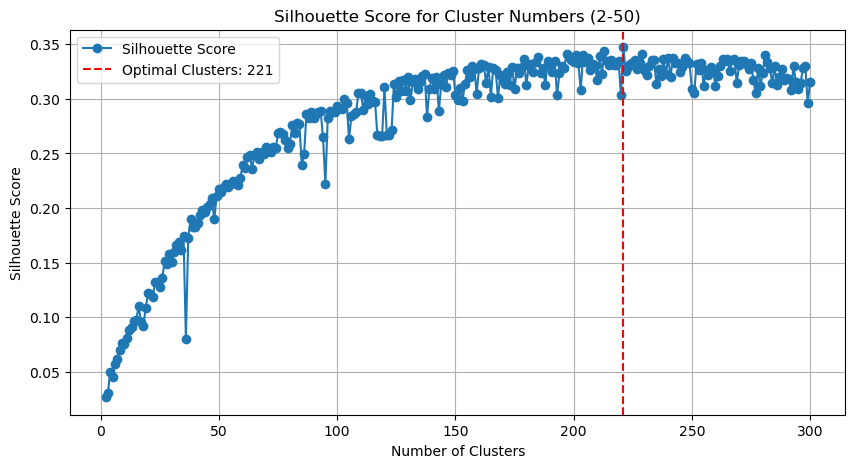

221

In [ ]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

cluster_range = range(2, 301)
silhouette_scores = []

# Calculate silhouette score for each number of clusters
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_reduced)
    silhouette_scores.append(silhouette_score(X_reduced, labels))

# optimal number of clusters
optimal_clusters = cluster_range[silhouette_scores.index(max(silhouette_scores))]

plt.figure(figsize=(10, 5))
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='-', label='Silhouette Score')
plt.axvline(optimal_clusters, color='red', linestyle='--', label=f'Optimal Clusters: {optimal_clusters}')
plt.title('Silhouette Score for Cluster Numbers (2-50)')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(True)
plt.show()

optimal_clusters


### Although Silhouette Score shows that the optimal number of clusters is 221, we decided to decrease the number to 25 to have more broad category names for analysis purposes. The category names were generated with the help of GenAI such as ChatGPT.

In [95]:
from sentence_transformers import SentenceTransformer, util
import torch
from tqdm import tqdm

# Load Sentence-BERT model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Define the cluster names (categories) based on previous output
cluster_names = [
    "Healthcare and Wellness", "Manufacturing and Retail Trade", "Energy, Mining, and Oil Industries",
    "Equipment and Machinery Manufacturing", "Government and Public Administration", "Metal and Wood Products",
    "Food and Beverage Industries", "Administrative and Support Services", "Design and Creative Services",
    "Transportation and Logistics Support", "Automotive Industry", "Education and Training Services",
    "Professional and Business Services", "Research and Biotechnology", "Construction and Building",
    "Furniture and Home Goods", "Performing Arts and Sports", "Wholesale Trade", "Transportation and Warehousing",
    "Real Estate and Office Services", "Textile and Paper Industries", "Chemical and Agricultural Products",
    "Durable and Non-durable Goods", "General Manufacturing", "Advanced Manufacturing and Electronics"
]

# Encode cluster names into embeddings
cluster_embeddings = model.encode(cluster_names, convert_to_tensor=True)

# Assign categories to industry names from the clusters
industry_names = clustered_df_clusters['Name'].tolist()  # Names from the combined dataset
assigned_categories = []

for industry_name in tqdm(industry_names, desc="Classifying industry names"):
    # Encode the industry name
    industry_embedding = model.encode(industry_name, convert_to_tensor=True)
    # Compute similarities with cluster names
    similarities = util.cos_sim(industry_embedding, cluster_embeddings)
    # Find the best matching cluster
    best_match_idx = int(similarities.argmax())
    best_category = cluster_names[best_match_idx]
    assigned_categories.append(best_category)

Classifying industry names: 100%|██████████| 679/679 [00:06<00:00, 109.14it/s]


In [96]:
api_industry_clusters = clustered_df_clusters[clustered_df_clusters['Name'].isin(api_industry['industry_name'])].copy()
api_industry_clusters['Source'] = 'API'

linkedin_industry_clusters = clustered_df_clusters[clustered_df_clusters['Name'].isin(linkedin_industry['industry_name'])].copy()
linkedin_industry_clusters['Source'] = 'LinkedIn'

# Merge into one DataFrame
final_clusters_df = pd.concat([api_industry_clusters.rename(columns={'Name': 'Industry Name', 'Cluster': 'Cluster ID'}),
                               linkedin_industry_clusters.rename(columns={'Name': 'Industry Name', 'Cluster': 'Cluster ID'})], ignore_index=True)

final_clusters_df.to_csv('mappings.csv')

In [101]:
# Assign the computed categories to the DataFrame
clustered_df_clusters['Cluster Name'] = assigned_categories

# Separate API and LinkedIn industry names with their respective cluster names
api_cluster_mapping = clustered_df_clusters[
    clustered_df_clusters['Name'].isin(api_industry['industry_name'])
][['Name', 'Cluster Name']].rename(columns={'Name': 'API Industry Name'})

linkedin_cluster_mapping = clustered_df_clusters[
    clustered_df_clusters['Name'].isin(linkedin_industry['industry_name'])
][['Name', 'Cluster Name']].rename(columns={'Name': 'LinkedIn Industry Name'})

# Save the results to separate CSV files
api_cluster_mapping.to_csv('api_mappings.csv', index=False)
linkedin_cluster_mapping.to_csv('linkedin_mappings.csv', index=False)

print("API and LinkedIn mappings have been saved successfully.")


API and LinkedIn mappings have been saved successfully.
